# Predict Attendance of Medical Appointment 

## Importing Libraries & Loading Data 

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

from datetime import datetime

from sklearn import model_selection, cross_validation, ensemble, preprocessing, svm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import learning_curve, ShuffleSplit, validation_curve
from sklearn.model_selection import GridSearchCV

D:\Anaconda\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
med_show = pd.read_csv('E:/Data Science/Experience/Medical_Appointment/appointment.csv')

In [3]:
med_show.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
med_show.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
med_show.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


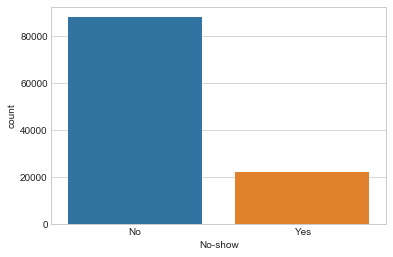

In [6]:
sns.countplot(x="No-show", data=med_show)

## Exploratory data analysis

In [7]:
med_show['No-attend'] = [0 if i == "No" else 1 for i in med_show['No-show']]

In [8]:
med_show = med_show[med_show.Age > 0]

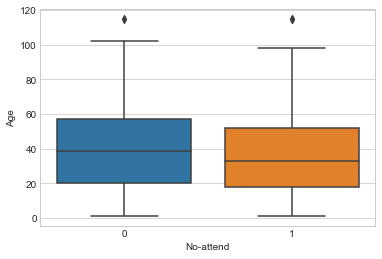

In [9]:
sns.boxplot(x="No-attend", y="Age", data=med_show)

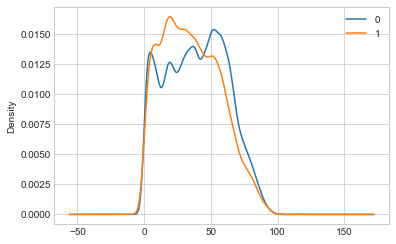

In [10]:
med_show.groupby('No-attend').Age.plot(kind='kde')
plt.legend(loc='upper right')

In [11]:
med_show['age_cat'] = pd.qcut(med_show['Age'], 5, labels=False)

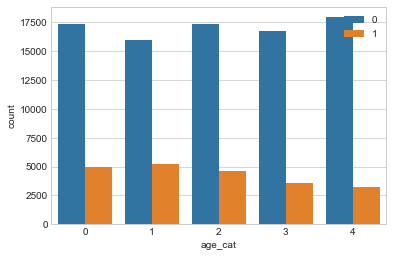

In [12]:
sns.countplot(x="age_cat", hue = "No-attend", data=med_show)
plt.legend(loc='best')

In [13]:
med_show['scheduled'] = med_show['ScheduledDay'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

In [14]:
med_show['appointment'] = med_show['AppointmentDay'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

In [15]:
med_show['diff_time'] =  (med_show['appointment'] - med_show['scheduled']).dt.days

In [16]:
med_show['hour'] = med_show['scheduled'].dt.hour

In [17]:
med_show['weekday'] = med_show['scheduled'].dt.weekday

In [18]:
med_show['diff_time'] = [0 if i < 0 else i for i in med_show['diff_time']]

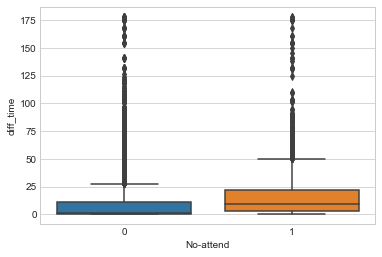

In [19]:
sns.boxplot(x="No-attend", y="diff_time", data=med_show)

In [20]:
med_show['diff_time_cat'] = [1 if i < 1 else i for i in med_show['diff_time']]
med_show['diff_time_cat'] = [2 if i > 1 and i <= 7 else i for i in med_show['diff_time_cat']]
med_show['diff_time_cat'] = [3 if i > 7 and i <= 30 else i for i in med_show['diff_time_cat']]
med_show['diff_time_cat'] = [4 if i > 30 else i for i in med_show['diff_time_cat']]

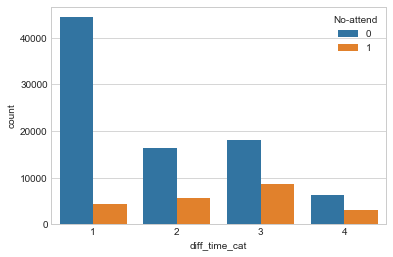

In [21]:
sns.countplot(x="diff_time_cat", hue = "No-attend", data=med_show)

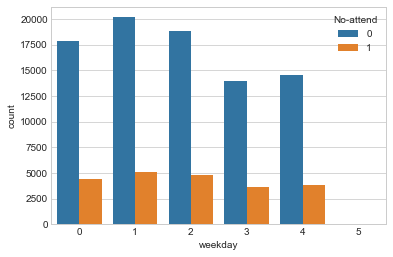

In [22]:
sns.countplot(x="weekday", hue = "No-attend", data=med_show)

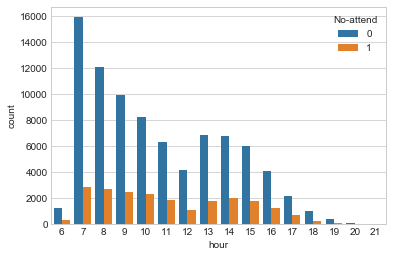

In [23]:
sns.countplot(x="hour", hue = "No-attend", data=med_show)

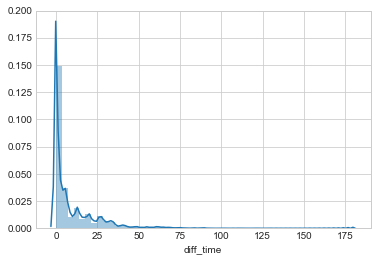

In [24]:
sns.distplot(med_show.diff_time);

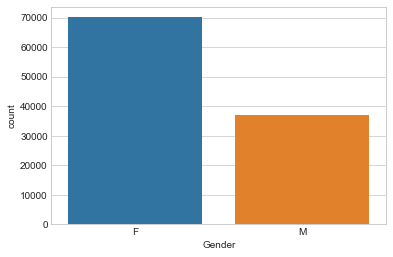

In [25]:
sns.countplot(x="Gender", data=med_show)

In [26]:
med_show.groupby(['No-attend'])['diff_time'].mean()

No-attend
0     8.152918
1    14.870295
Name: diff_time, dtype: float64

In [27]:
med_show['sex'] = [1 if i == 'M' else 0 for i in med_show['Gender']]

In [28]:
med_show['area'] = pd.factorize(med_show['Neighbourhood'])[0]

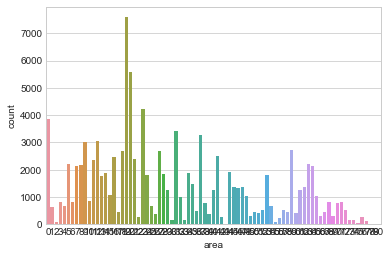

In [29]:
sns.countplot(x="area", data=med_show)

### Train of model

In [30]:
X = med_show[['age_cat','Hipertension', 'Alcoholism', 'Diabetes', 
                         'area', 'Scholarship', 'sex', 'SMS_received', 'hour', 'weekday', 'diff_time_cat']]


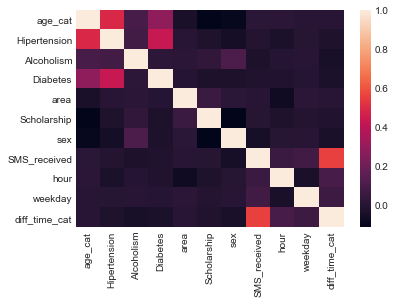

In [31]:
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [32]:
y = med_show['No-attend']

In [33]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=1)

In [34]:
###Lets check the final table

In [35]:
x_train.head()

,age_cat,Hipertension,Alcoholism,Diabetes,area,Scholarship,sex,SMS_received,hour,weekday,diff_time_cat
108487,0,0,0,0,64,0,1,1,13,0,4
100582,1,0,0,0,9,0,1,0,8,4,1
108202,2,0,0,0,19,0,1,0,14,2,1
61902,1,0,0,0,21,0,0,0,7,1,3
62447,1,0,0,0,45,1,0,1,9,1,2


## Build Random Forest Model

In [36]:

clf = ensemble.RandomForestClassifier(max_depth = 12, n_estimators= 10, verbose=0, class_weight= {0:1, 1:3})
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [37]:
y_pred = clf.predict(x_test)

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.40%


In [39]:
clf.score(x_test, y_test)

0.69399009253201238

In [40]:
clf.score(x_train, y_train)

0.7303041278668988

In [41]:
roc_auc_score(y_test, y_pred)

0.64422219549899251

In [42]:
confusion_matrix(y_test, y_pred)

array([[12420,  4643],
       [ 1905,  2430]], dtype=int64)

In [43]:
importances = clf.feature_importances_

Feature ranking:
1. feature 10 (0.457023)
2. feature 4 (0.170308)
3. feature 8 (0.108271)
4. feature 0 (0.077034)
5. feature 9 (0.064565)
6. feature 7 (0.037568)
7. feature 6 (0.024243)
8. feature 1 (0.016528)
9. feature 5 (0.016409)
10. feature 2 (0.014435)
11. feature 3 (0.013615)


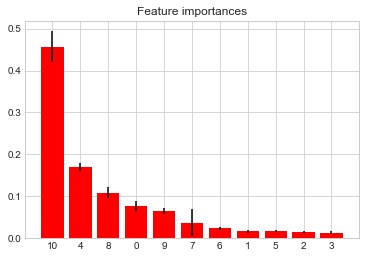

In [44]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Standardize the X matrix

In [45]:
X_scaled = preprocessing.scale(X)

Accuracy: 79.78%
Feature ranking:
1. feature 10 (0.559791)
2. feature 7 (0.197226)
3. feature 0 (0.127371)
4. feature 8 (0.062659)
5. feature 1 (0.022976)
6. feature 4 (0.019862)
7. feature 5 (0.005590)
8. feature 9 (0.002051)
9. feature 2 (0.001172)
10. feature 6 (0.001054)
11. feature 3 (0.000247)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


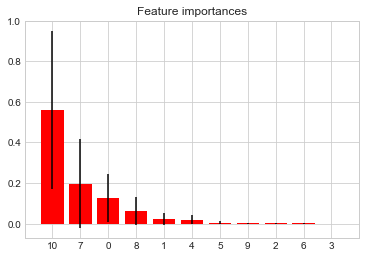

In [46]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.30, random_state=50)
clf = ensemble.RandomForestClassifier(max_depth = 4, n_estimators= 5, verbose=1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()